# Connect G-Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
default_dir = "/content/drive/MyDrive/..."
os.chdir(default_dir)

In [ ]:
!ls

 Churn_Modelling.csv			'[Sandbox] Churn_Prediction.ipynb'
 churn-problem-for-bank-customer.ipynb	 v1_Churn_Prediction.ipynb
'[For Tutor] Churn_Prediction.ipynb'


# Import Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, GridSearchCV)

from sklearn.preprocessing import (
    scale, LabelEncoder, StandardScaler,
    MinMaxScaler, Normalizer, RobustScaler
)

from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_score, confusion_matrix, recall_score,
    roc_auc_score, roc_curve
)

# to display all columns and rows:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# The number of numbers that will be shown after the comma.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 1.&nbsp;Load Dataset

## 1.1 Description

Data Set Story:
- It consists of 10000 observations and 12 variables.
- Independent variables contain information about customers.
- Dependent variable refers to customer abandonment.


Features:
- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany / France / Spain)
- Gender: Gender (Female / Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: Bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Abandoned or not? (0 = No, 1 = Yes)

In [ ]:
df = pd.read_csv("Churn_Modelling.csv", index_col=0)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


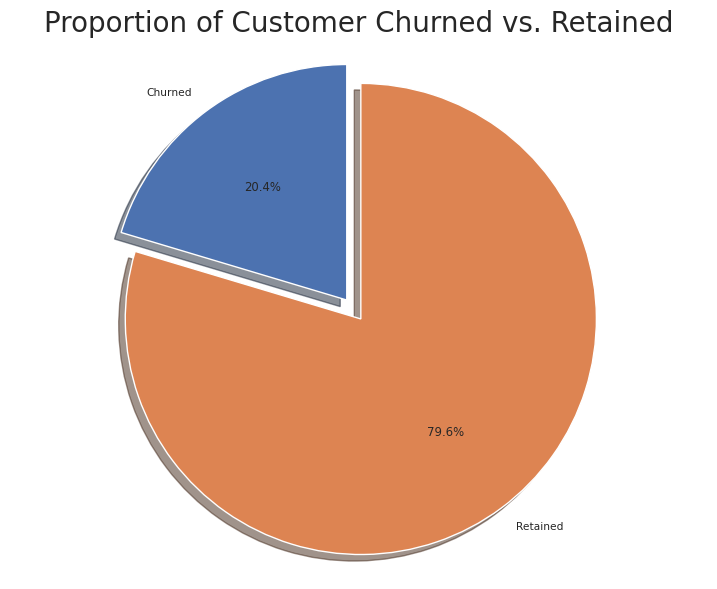

In [ ]:
labels = 'Churned', 'Retained'
sizes = [
    df.Exited[df['Exited']==1].count(),
    df.Exited[df['Exited']==0].count()
]
explode = (0, 0.1)

fig1, ax1 = plt.subplots(figsize=(9, 7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of Customer Churned vs. Retained", size = 20)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


# 2.&nbsp;EDA


## 2.1 Data Preparation

In [ ]:
dependent_variable_name = "Exited"

In [ ]:
def show_unique_count_variables(df):
    for index, value in df.nunique().items():
        print(str(index) + "\t\t:" + str(value))

def data_prepare():
    df_prep = df.copy()

    missing_value_len = df.isnull().any().sum()
    if missing_value_len == 0:
        print("No Missing Value")
    else:
        print("Investigate Missing Value, Missing Value : " + str(missing_value_len))
    print("\n")

    show_unique_count_variables(df=df_prep)

    df_prep['Tenure'] = df_prep.Tenure.astype(np.float)
    df_prep['NumOfProducts'] = df_prep.NumOfProducts.astype(np.float)
    return df_prep

### 2.2. Outliers Observe (LOF method and Supress)
#### 2.2.1. Outlier Editing

In [ ]:
def show_outliers(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=2, ncols=5,
        gridspec_kw=dict(hspace=0.3), figsize=(12,9)
    )
    fig.tight_layout()
    for ax, col in zip(axes.flatten(), df_num_cols.columns):
        sns.boxplot(x=df_num_cols[col], color='green', ax=ax)
    fig.suptitle('Observing Outliers', color='r', fontsize=14)

#### 2.2.2. Visualization of outliers according to the LOF method

In [ ]:
def lof_observation(df):

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    df_outlier = df_num_cols.astype("float64")
    clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    clf.fit_predict(df_outlier)
    df_scores = clf.negative_outlier_factor_
    scores_df = pd.DataFrame(np.sort(df_scores))

    scores_df.plot(
        stacked=True, xlim=[0, 20], color='r',
        title='Visualization of outliers according to the LOF method',
        style='.-'); # first 20 observe

    th_val = np.sort(df_scores)[2]
    outliers = df_scores > th_val
    df = df.drop(df_outlier[~outliers].index)
    df.shape
    return df

#### 2.2.3. Outlier suppression

In [ ]:
def clear_outliers(df):
    # For Age
    Q1 = df["Age"].quantile(0.25)
    Q3 = df["Age"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed below lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["Age"][(df["Age"] > upper)]
    df["Age"][df_outlier.index] = upper

    # For Credit Score
    Q1 = df["CreditScore"].quantile(0.25)
    Q3 = df["CreditScore"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed above lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["CreditScore"][(df["CreditScore"] < lower)]
    df["CreditScore"][df_outlier.index] = lower
    return df

#### 2.2.4. Outiler Process

In [ ]:
def outlier_process(df):
    df_outlier = lof_observation(df=df)
    df_outlier = clear_outliers(df=df_outlier)
    return df_outlier

### 2.3. Data Analysis
#### 2.3.1. Dependent variable distribution

In [ ]:
def show_dependent_variable(df):
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    sns.countplot(x='Geography', hue='Exited', data=df, ax=axarr[0][0])
    sns.countplot(x='Gender', hue='Exited', data=df, ax=axarr[0][1])
    sns.countplot(x='HasCrCard', hue='Exited', data=df, ax=axarr[0][2])
    sns.countplot(x='IsActiveMember', hue='Exited', data=df, ax=axarr[1][0])
    sns.countplot(x='NumOfProducts', hue='Exited', data=df, ax=axarr[1][1])
    sns.countplot(x='Tenure', hue='Exited', data=df, ax=axarr[1][2])
    zero, one = df[dependent_variable_name].value_counts()
    print("Dependent variable distribution;")
    print(dependent_variable_name + " 0 count:", zero)
    print(dependent_variable_name + " 1 count:", one)

#### 2.3.2. Numeric columns distribution observation

In [ ]:
def show_numeric_columns_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]
    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle('Structures of numeric variables', color='r', fontsize=18)
    plt.show()

#### 2.3.3. Status of other variables according to dependent variable

In [ ]:
def show_dependent_variable_cross_others_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_dependent_var = df[df[dependent_variable_name]==1]
    df_num_cols = df_dependent_var.select_dtypes(include=numerics)
    columns = df_num_cols.columns[:len(df_num_cols.columns)]

    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle(dependent_variable_name + ' Status of other variables according to 1 dependent variable', color='r', fontsize=18)
    plt.show()

#### 2.3.4. Categorical variables are observed according to the dependent variable

In [ ]:
def show_dependent_variable_cross_categorical_distributions(df, categorical_columns):
    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=int(len(categorical_columns)/2 ),
        ncols=2,
        figsize=(7,9)
    )
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), categorical_columns):
        sns.countplot(x=df[col], hue=dependent_variable_name, data=df, ax=ax)
    fig.suptitle('Categorical variables are monitored according to the dependent variable', color='r', fontsize=1)


#### 2.3.5. The main method that started all data analysis

In [ ]:
def show_data_analysis(df):
    show_dependent_variable(df)
    show_numeric_columns_distributions(df)
    show_dependent_variable_cross_others_distributions(df)
    show_dependent_variable_cross_categorical_distributions(
        df=df_outlier,
        categorical_columns=["Gender", "Geography", "HasCrCard", "IsActiveMember"]
    )

## 3.&nbsp;Feature Engineering

In [ ]:
def credit_score_table(row):
    credit_score = row.CreditScore
    if credit_score < 300:
      return "Deep"
    elif 300 <= credit_score < 500:
        return "Very_Poor"
    elif 500 <= credit_score < 601:
        return "Poor"
    elif 601 <= credit_score < 661:
        return "Fair"
    elif 661 <= credit_score < 781:
        return "Good"
    elif 781 <= credit_score < 851:
        return "Excellent"
    else:
        return "Top"

### 3.2. Product utilization RATE by YEAR

In [ ]:
def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure

    if number_of_products == 0:
        return 0

    if tenure == 0:
        return number_of_products

    rate = number_of_products/tenure
    return rate

### 3.3. Product utilization rate by estimated SALARY

In [ ]:
def product_utilization_rate_by_estimated_salary(row):
    number_of_products = row.number_of_products
    estimated_salary = row.EstimatedSalary

    if number_of_products == 0:
        return 0

    rate = number_of_products / estimated_salary
    return rate

### 3.4. According to countries monthly average salaries

reference: [Link](https://en.wikipedia.org/wiki/List_of_European_countries_by_average_wage)

In [ ]:
def countries_monthly_average_salaries(row):
    fr = 3696
    de = 4740
    sp = 2257
    salary = row.EstimatedSalary / 12
    country = row.Geography # Germany, France and Spain

    if country == 'Germany':
        return salary / de
    elif country == "France":
        return salary / fr
    elif country == "Spain":
        return salary / sp

### 3.5. The main method that started all Feature Engineering

In [ ]:
def feature_engineering(df, is_show_graph = False):
    df_fe = df.copy()

    balance_salary_rate = 'balance_salary_rate'
    df_fe[balance_salary_rate] = df_fe.Balance / df_fe.EstimatedSalary

    df_fe = df_fe.assign(
        product_utilization_rate_by_year=df_fe.apply(
            lambda x: product_utilization_rate_by_year(x),
            axis=1
            )
        )

    tenure_rate_by_age = 'tenure_rate_by_age'
    df_fe[tenure_rate_by_age] = df_fe.Tenure/(df_fe.Age-17)

    credit_score_rate_by_age = 'credit_score_rate_by_age'
    df_fe[credit_score_rate_by_age] = df_fe.CreditScore/(df_fe.Age-17)

    product_utilization_rate_by_salary = 'product_utilization_rate_by_salary'

    credit_score_rate_by_salary = 'credit_score_rate_by_salary'
    df_fe[credit_score_rate_by_salary] = df_fe.CreditScore/(df_fe.EstimatedSalary)

    if is_show_graph:
        fig, axes = plt.subplots(
            nrows=2, ncols=2, figsize=(20,12))
        fig.tight_layout()
        sns.boxplot(
            y=balance_salary_rate,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][0]
        )
        sns.boxplot(
            y=product_utilization_rate_by_year,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][1]
        )
        plt.ylim(-1, 5)

    df_fe = df_fe.assign(credit_score_table=df_fe.apply(lambda x: credit_score_table(x), axis=1))
    df_fe = df_fe.assign(countries_monthly_average_salaries = df_fe.apply(lambda x: countries_monthly_average_salaries(x), axis=1))
    return df_fe

# 4.&nbsp;Data Encoding

In [ ]:
def data_encoding(df):
    df_model = df.copy()
    # >>>> Categorical columns <<<<<
    non_encoding_columns = [
        "Geography", "HasCrCard","IsActiveMember",
        "Gender", "NumOfProducts", "Tenure", "credit_score_table"]

    df_non_encoding = df_model[non_encoding_columns]
    df_model = df_model.drop(non_encoding_columns, axis=1)
    df_encoding = df_non_encoding.copy()

    encoder = LabelEncoder()
    df_encoding["gender_category"] = encoder.fit_transform(df_non_encoding.Gender)
    df_encoding["country_category"] = encoder.fit_transform(df_non_encoding.Geography)
    df_encoding["credit_score_category"] = encoder.fit_transform(df_non_encoding.credit_score_table)

    df_encoding.reset_index(drop=True, inplace=True)
    df_model.reset_index(drop=True, inplace=True)
    df_model = pd.concat([df_model, df_encoding], axis=1)

    df_model = df_model.drop(
        ["Geography", "Gender" , "CustomerId", "Surname",
         "credit_score_table", "CreditScore", "EstimatedSalary"],
        axis=1)

    df_model = df_model.reset_index()
    df_model = df_model.drop('index', axis=1)

    df_model.loc[df_model.HasCrCard==0, 'credit_card_situation'] = -1
    df_model.loc[df_model.IsActiveMember==0, 'is_active_member'] = -1
    return df_model

In [ ]:
df[df.IsActiveMember==0]["Exited"].value_counts()

0    3547
1    1302
Name: Exited, dtype: int64

# 5.&nbsp;Model Preparation

In [ ]:
def model_prepare(df_model):

    X = df_model.loc[:, df_model.columns != dependent_variable_name]
    y = df_model[dependent_variable_name]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test

### 5.1 Part of Data Train

In [ ]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('XGBoost', XGBClassifier()))
    models.append(('LightGBM', LGBMClassifier()))

    res_cols = [
        'model', 'accuracy_score', 'scale_method',
        "0_precision", "0_recall", "1_precision", "1_recall"
    ]
    df_result = pd.DataFrame(columns=res_cols)

    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']
        res_vals = [name, score, "NA", zero_report['precision'], zero_report['recall'], one_report['precision'], one_report['recall']]
        df_result.at[index, res_cols] = res_vals
        index += 1
    return df_result.sort_values("accuracy_score", ascending=False)

# 6.&nbsp;HELPER Functions

In [ ]:
# Function to give best model score and parameters

def best_model(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)

def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method);
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2);
    return (auc_score, fpr_df, tpr_df)

from matplotlib import rc, rcParams
def plot_confusion_matrix(
    cm, classes,
    normalize=False,
    title='Confusion Matrix',
    cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.rcParams.update({'font.size': 16})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 7.&nbsp;Data Cleaning

No Missing Value


CustomerId		:10000
Surname		:2932
CreditScore		:460
Geography		:3
Gender		:2
Age		:70
Tenure		:11
Balance		:6382
NumOfProducts		:4
HasCrCard		:2
IsActiveMember		:2
EstimatedSalary		:9999
Exited		:2
When age and credit score is printed below lower score:  14.0 and upper score:  62.0
When age and credit score is printed above lower score:  383.0 and upper score:  919.0


<ipython-input-37-88e44ad234b5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Age"][df_outlier.index] = upper
<ipython-input-37-88e44ad234b5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CreditScore"][df_outlier.index] = lower


Dependent variable distribution;
Exited 0 count: 7963
Exited 1 count: 2037


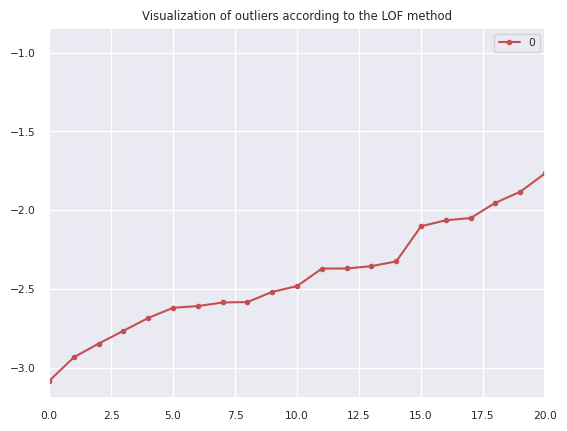

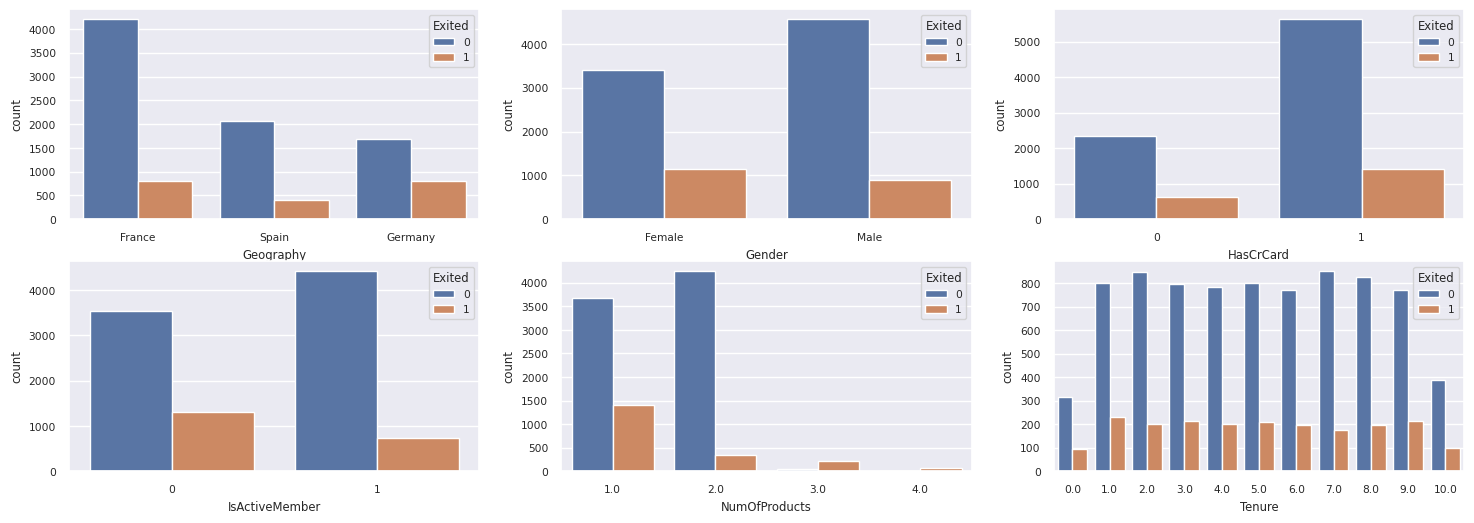

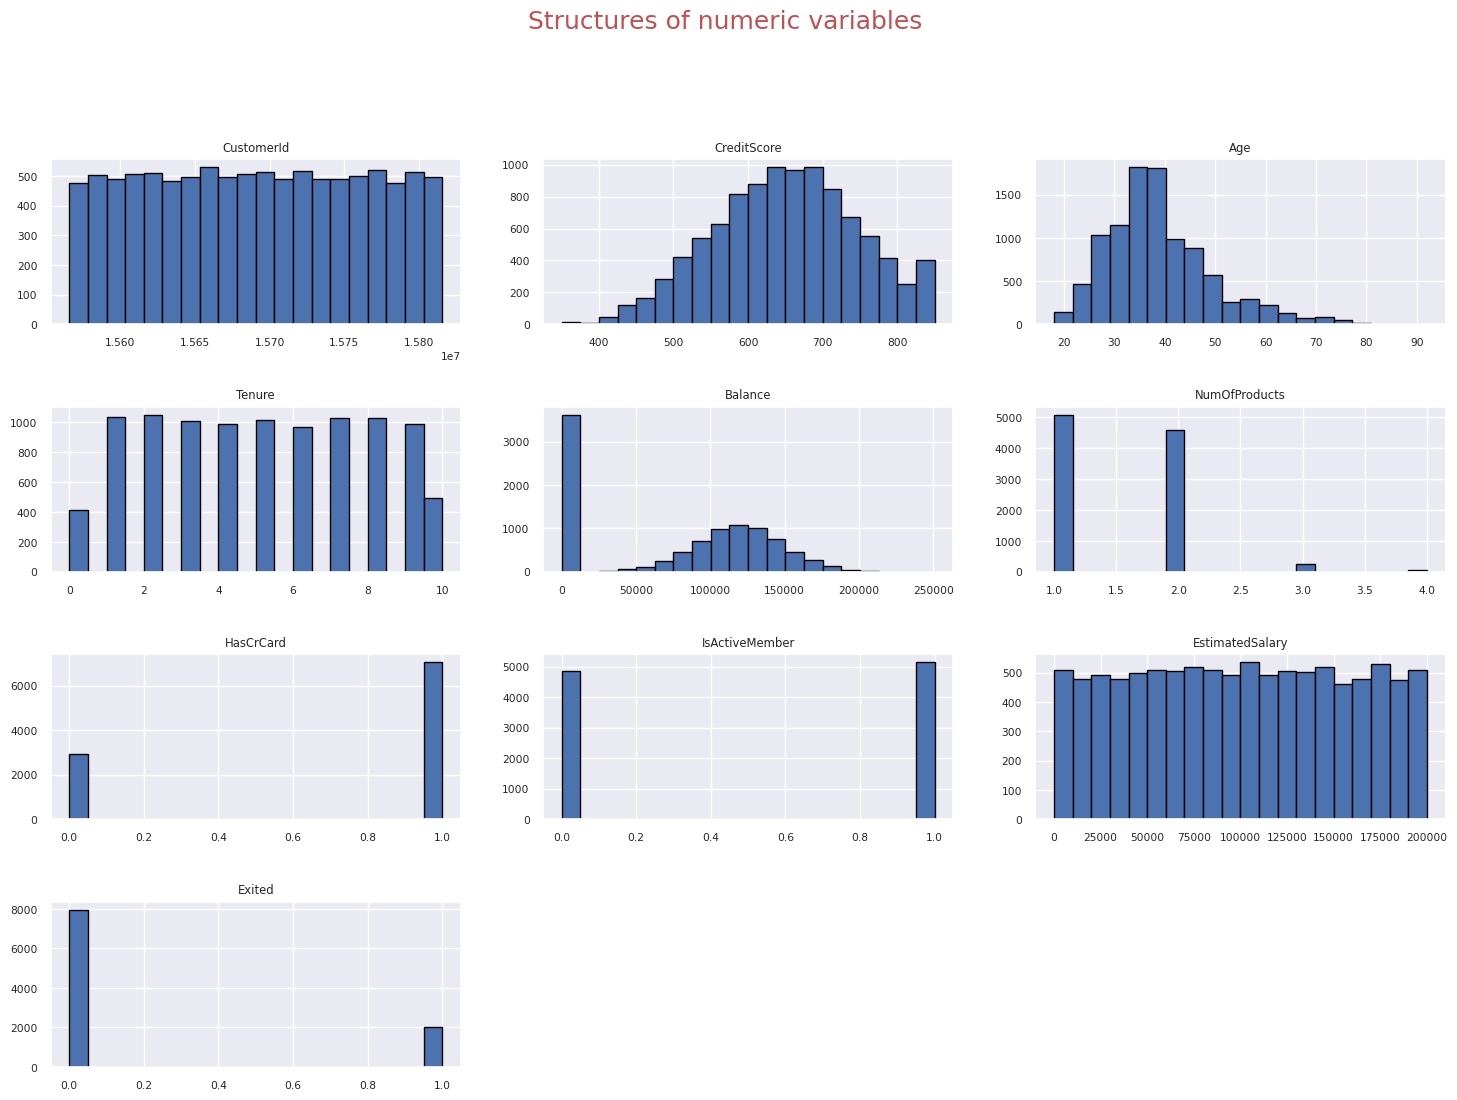

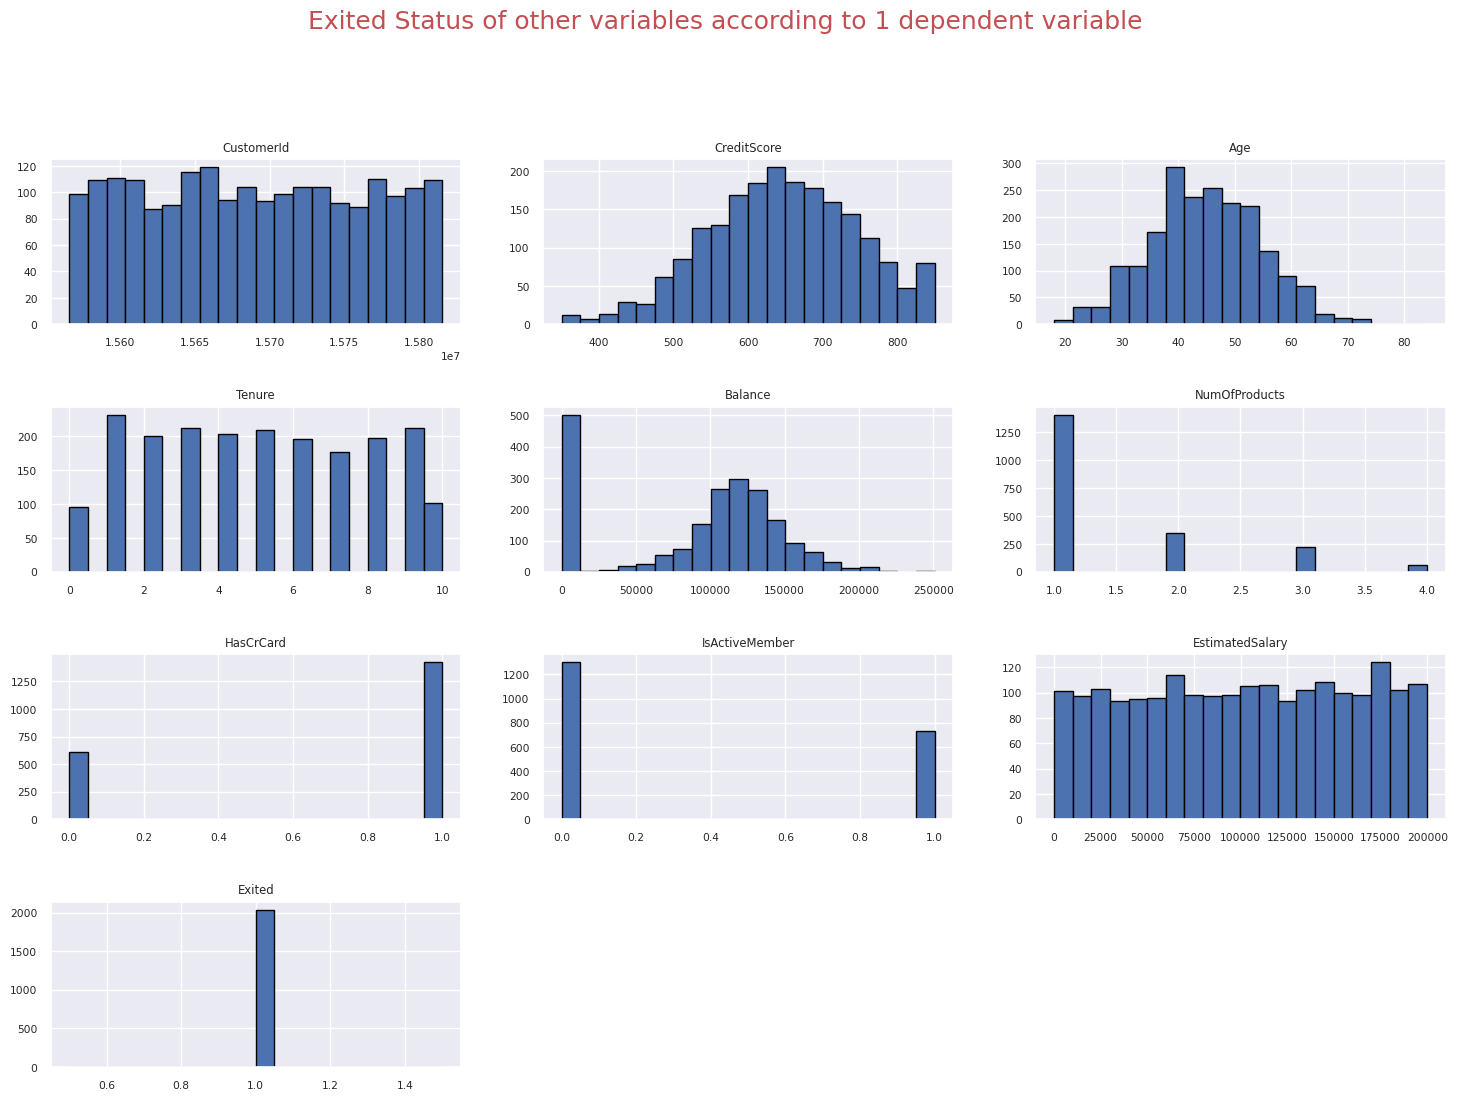

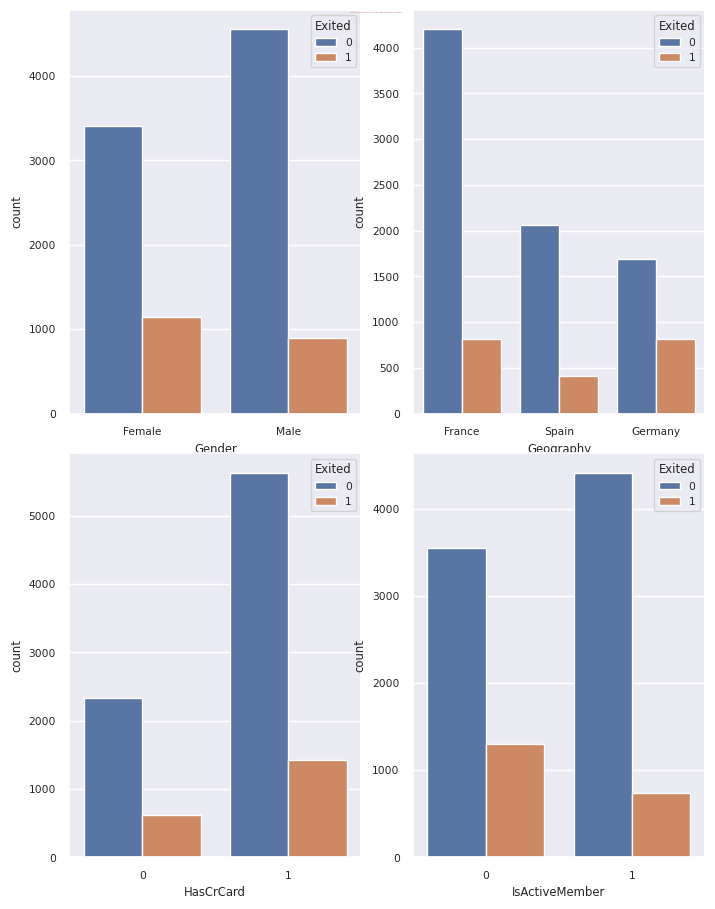

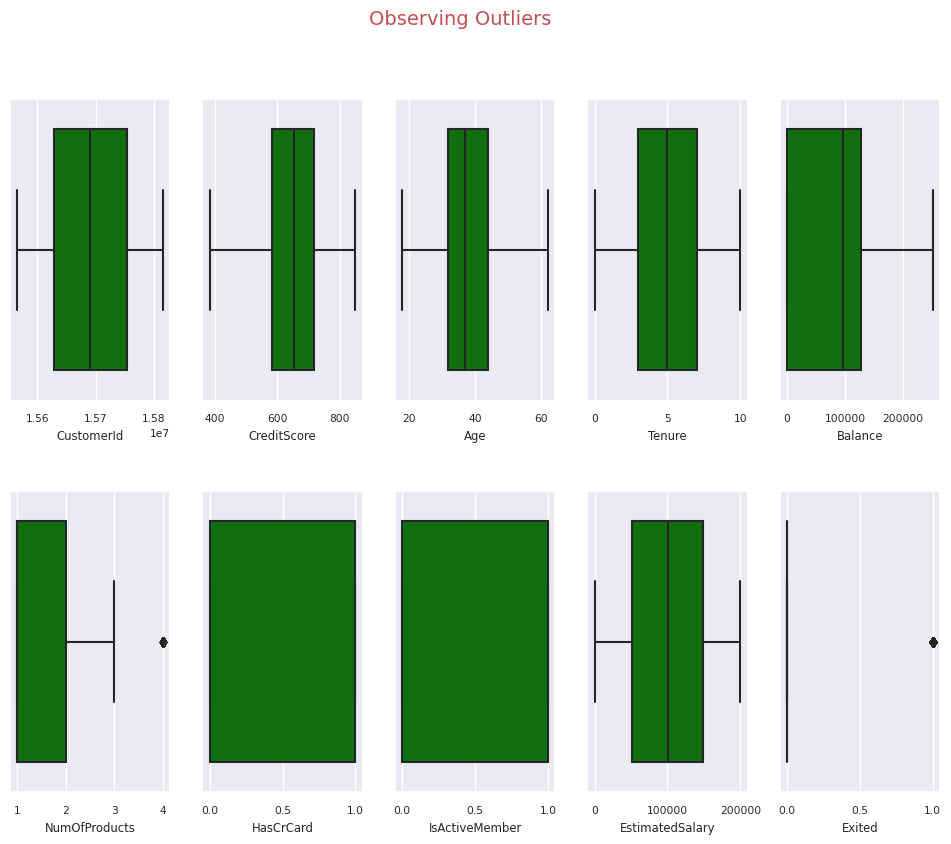

In [ ]:
df_prep = data_prepare()
df_outlier = outlier_process(df=df_prep)

show_data_analysis(df_prep)
show_outliers(df=df_outlier)

Let's see after feature engineering:

In [ ]:
df_fe = feature_engineering(df = df_outlier)
df_fe.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,credit_score_table,countries_monthly_average_salaries
RowNumber,,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1.00,1,1,101348.88,1,0.00,0.50,0.08,24.76,0.01,Fair,2.29
2,15647311,Hill,608,Spain,Female,41,1.00,83807.86,1.00,0,1,112542.58,0,0.74,1.00,0.04,25.33,0.01,Fair,4.16
3,15619304,Onio,502,France,Female,42,8.00,159660.80,3.00,1,0,113931.57,1,1.40,0.38,0.32,20.08,0.00,Poor,2.57


And see after data encoding:

In [ ]:
df_encoded = data_encoding(df_fe)
df_encoded.drop(
    columns=['credit_card_situation', 'is_active_member'], inplace=True)
df_encoded.head(5)

,Age,Balance,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,countries_monthly_average_salaries,HasCrCard,IsActiveMember,NumOfProducts,Tenure,gender_category,country_category,credit_score_category
0,42,0.00,1,0.00,0.50,0.08,24.76,0.01,2.29,1,1,1.00,2.00,0,0,1
1,41,83807.86,0,0.74,1.00,0.04,25.33,0.01,4.16,0,1,1.00,1.00,0,2,1
2,42,159660.80,1,1.40,0.38,0.32,20.08,0.00,2.57,1,0,3.00,8.00,0,0,3
3,39,0.00,0,0.00,2.00,0.05,31.77,0.01,2.12,0,0,2.00,1.00,0,0,2
4,43,125510.82,0,1.59,0.50,0.08,32.69,0.01,2.92,1,1,1.00,2.00,0,2,0


Now, let's see correlation graph:

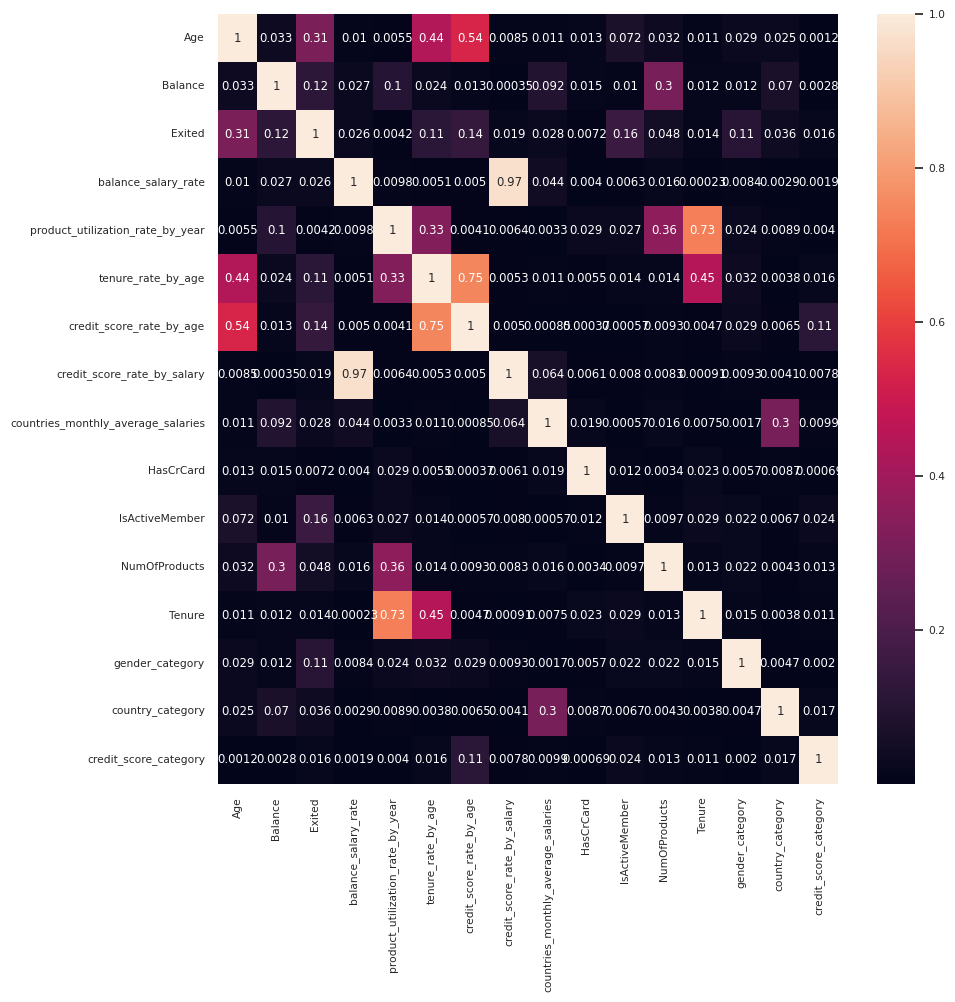

In [ ]:
correlation = df_encoded.corr().abs()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True)
plt.show()

List of correlation scores:

In [ ]:
corrs_results = df_encoded.corrwith(df_encoded["Exited"]).abs().nlargest(24)
corrs_results

Exited                               1.00
Age                                  0.31
IsActiveMember                       0.16
credit_score_rate_by_age             0.14
Balance                              0.12
tenure_rate_by_age                   0.11
gender_category                      0.11
NumOfProducts                        0.05
country_category                     0.04
countries_monthly_average_salaries   0.03
balance_salary_rate                  0.03
credit_score_rate_by_salary          0.02
credit_score_category                0.02
Tenure                               0.01
HasCrCard                            0.01
product_utilization_rate_by_year     0.00
dtype: float64

# 8.&nbsp;Apply Model

In [ ]:
# model_prepare test, train split 0.2
X_train, X_test, y_train, y_test = model_prepare(df_model=df_encoded)

### 8.1. Logistic Regression Model

Have a look with Logistic Regression.

In [ ]:
logr_model = LogisticRegression()
logr_model.fit(X_train, y_train)
y_pred = logr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score of Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

           0     0.8502    0.9669    0.9048      1632
           1     0.6250    0.2446    0.3516       368

    accuracy                         0.8340      2000
   macro avg     0.7376    0.6057    0.6282      2000
weighted avg     0.8088    0.8340    0.8030      2000

Accuracy score of Logistic Regression:  0.834


### 8.2. Model Training

This is for all LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, and LGBMClassifier model objects:

In [ ]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('XGBoost', XGBClassifier()))
    models.append(('LightGBM', LGBMClassifier()))

    res_cols = ["model", "accuracy_score", "scale_method", "0_precision", "0_recall", "1_precision", "1_recall"]
    df_result = pd.DataFrame(columns=res_cols)
    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']

        idx_res_values = [name, score, "NA", zero_report['precision'], zero_report['recall'], one_report['precision'], one_report['recall']]
        # df_result.at[index, res_cols] = idx_res_values
        df_result.loc[index, res_cols] = idx_res_values
        index += 1
    df_result = df_result.sort_values("accuracy_score", ascending=False).reset_index(drop=True)
    return df_result

In [ ]:
training_result = data_training(X_train, X_test, y_train, y_test)
training_result

[LightGBM] [Info] Number of positive: 1668, number of negative: 6329
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 7997, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208578 -> initscore=-1.333517
[LightGBM] [Info] Start training from score -1.333517


,model,accuracy_score,scale_method,0_precision,0_recall,1_precision,1_recall
0,LightGBM,0.88,NA,0.90,0.95,0.72,0.53
1,RF,0.87,NA,0.89,0.96,0.73,0.46
2,GBM,0.87,NA,0.89,0.96,0.71,0.48
3,XGBoost,0.86,NA,0.89,0.95,0.67,0.49
4,KNN,0.85,NA,0.88,0.94,0.61,0.44
5,LOGR,0.83,NA,0.85,0.97,0.62,0.24
6,CART,0.79,NA,0.88,0.85,0.43,0.48


# 9.&nbsp;Model Tuning

### 9.1. XGBoost Tuning

In [ ]:
xgb_model=XGBClassifier(
    learning_rate=0.23, max_delta_step=5,
    objective='reg:logistic', n_estimators=92,
    max_depth=5, eval_metric="logloss", gamma=3, base_score=0.5)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      1632
           1       0.75      0.49      0.60       368

    accuracy                           0.88      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.87      0.88      0.87      2000

Accuracy score of Tuned XGBoost Regression:  0.8765


### 9.2. Random Forest Tuning

In [ ]:
'''
param_grid = {
    'max_depth': [3, 5, 6, 7, 8],
    'max_features': [2, 4, 6, 7, 8, 9],
    'n_estimators' : [50, 100],
    'min_samples_split': [3, 5, 6, 7]
}

randFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, refit = True, verbose = 0)
randFor_grid.fit(X_train, y_train)
best_model(randFor_grid)
'''

# skipped, running too long

Using the parameters and get final version accuracy score.

In [ ]:
rnd_model = RandomForestClassifier(
    max_depth=8,
    max_features=6,
    min_samples_split=6,
    n_estimators=50
)

rnd_model.fit(X_train, y_train)
y_pred = rnd_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.92      1632
           1       0.74      0.45      0.56       368

    accuracy                           0.87      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.86      0.87      0.86      2000

Accuracy score of tuned Random Forest model:  0.8705


### 9.3. LightGBM Tuning

In [ ]:
lgbm_model = LGBMClassifier(
    silent = 0, learning_rate = 0.09, max_delta_step = 2,
    n_estimators = 100, boosting_type = 'gbdt',
    max_depth = 10, eval_metric = "logloss",
    gamma = 3, base_score = 0.5
)

lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1668, number of negative: 6329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info

# 10.&nbsp;Confusion Matrix

Confusion matrix, without normalization


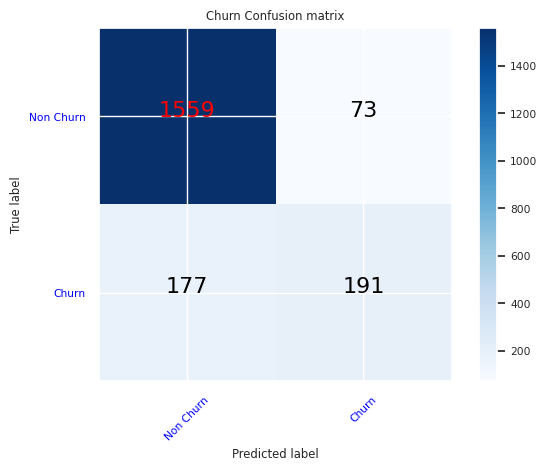

In [ ]:
cfm = confusion_matrix(y_test, y_pred=y_pred)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix'
)

tn, fp, fn, tp = cfm.ravel()

#print("True Negatives: ",tn)
#print("False Positives: ",fp)
#print("False Negatives: ",fn)
#print("True Positives: ",tp)

# 11.&nbsp;ROC Curve

In [ ]:
! pip install scikit-plot

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


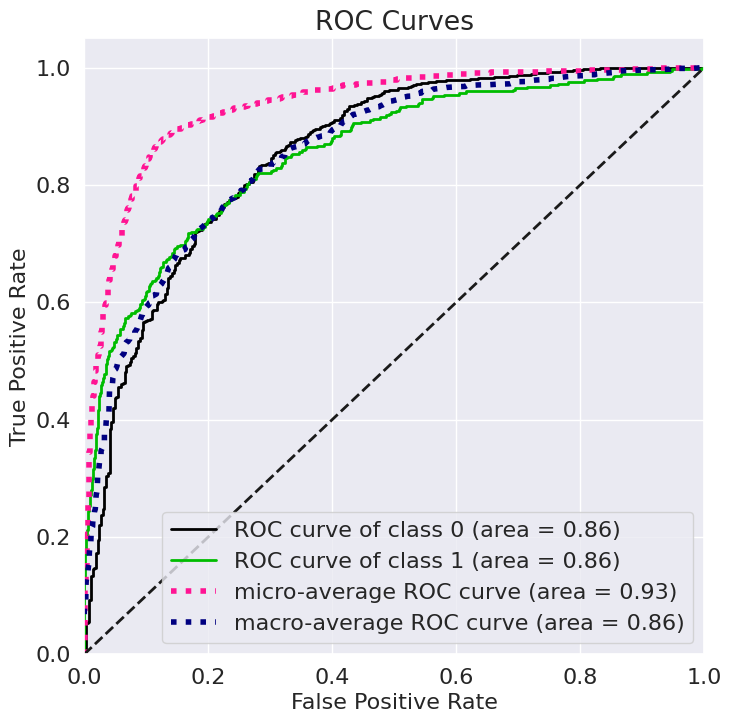

In [ ]:
import scikitplot as skplt
y_pred_proba = lgbm_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba, figsize=(8,8))

plt.show()

# 12.&nbsp;Feature Importance

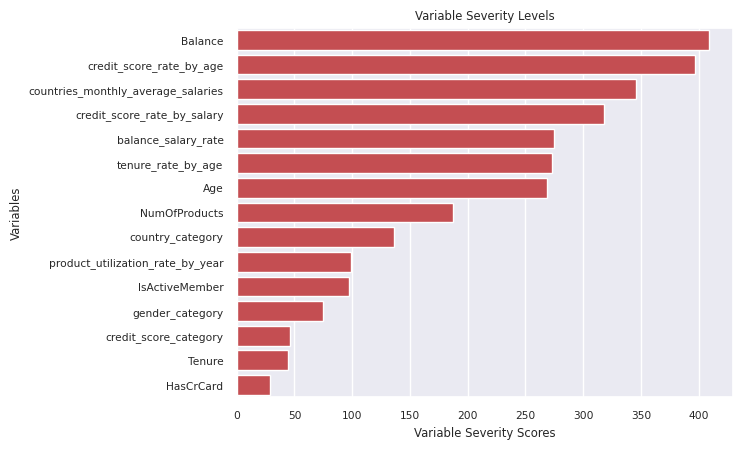

In [ ]:
feature_index = df_encoded.loc[:, df_encoded.columns != dependent_variable_name]

feature_importance = pd.Series(
    lgbm_model.feature_importances_,
    index=feature_index.columns
)
feature_importance = feature_importance.sort_values(ascending=False)

sns.barplot(
    x=feature_importance,
    y=feature_importance.index,
    color='r',
    saturation=1
)

plt.xlabel('Variable Severity Scores')
plt.ylabel('Variables')
plt.title('Variable Severity Levels')
plt.show()

# 13.&nbsp;Conclusion

